In [1]:
# Imports
from prelim_calculations import Calculate
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import csv
from demand_calculation import *
import os
import time

In [12]:
class Request:

    def __init__(self):
        self.API_URL = "https://phonebox.tegola.org.uk/api_jsonrpc.php"
        self.NUM_VALUES = 1        # Data is collected every 3 minutes
        self.username = "yeyao"
        self.password = "ci5WeJoh"

        # Router -> Internet IDs
        self.rti_ids = [["47072", "47073", "47068", "47061"], ["47707", "47722", "47711"], ["45623"], ["46494"], ["46640", "46641"], 
           ["46131"], ["52250", "44809", "44811", "48758", "48759", "48760", "48761"], 
           ["46367", "46359", "46362", "46365", "46366"], ["45626", "45625", "45639"]]

        # Internet -> Router IDs
        self.itr_ids = [["47123", "47124", "47119", "47112"], ["47851", "47866", "47855"], ["45791"], ["46539"], ["46682", "46683"], 
           ["46074"], ["44896", "44898", "48803", "48804", "48805", "48806", "52256"], 
           ["46404", "46407", "46410", "46411", "46412"], ["45794", "45793", "45807"]]
        
        self.mhi_gateway_upstream_id = "47118"
        self.mhi_gateway_downstream_id = "47067"
        self.smo_gateway_upstream_id = "47852"
        self.smo_gateway_downstream_id = "47708"
        self.gateway_id_list = [self.mhi_gateway_upstream_id, self.mhi_gateway_downstream_id, self.smo_gateway_upstream_id, self.smo_gateway_downstream_id]
        self.token = self.get_auth_token()

    # Generate the authentication token for login
    def get_auth_token(self):
        result = ""

        # JSON login request
        try:
            data = {
            "jsonrpc": "2.0",
            "method": "user.login",
            "params": {
                "user": self.username,
                "password": self.password
            },
            "id": 1,
            "auth": None
            }
            req = requests.post(self.API_URL, json=data)
            result = req.json()["result"]
        except:
            exit()
        return result

    # Build a trend request
    def build(self, start, end, ids):
        data = {
            "jsonrpc": "2.0",
            "method": "trend.get",
            "params": {
                "time_from": int(time.mktime(start)),
                "time_till": int(time.mktime(end)),
                "itemids": ids,
                "sortfield": "clock",
                "sortorder": "DESC",
                "output": [
                    "itemid",
                    "clock",
                    "value_avg" # should be able to change this to max/min if necessary
                ]
            },
            "auth": self.token,
            "id": 1
        }

        req = requests.post(API_URL, json=data)
        return ast.literal_eval(req.text)["result"]

In [13]:
# Retrieve all the data for the last month of gateway traffic
start_date = datetime.datetime(2023, 1, 1, 0, 0).timetuple()
end_date = datetime.datetime(2023, 1, 31, 23, 59).timetuple()
req = Request()
# item 1: upstream mhi, item 2: downstream mhi, item 3: upstream smo, item 4: downstream smo
dataset = [req.build(start_date, end_date, id) for id in req.gateway_id_list]

[[{'itemid': '47118', 'clock': '1674183600', 'value_avg': '1231'}, {'itemid': '47118', 'clock': '1674187200', 'value_avg': '1272'}, {'itemid': '47118', 'clock': '1674190800', 'value_avg': '1252'}, {'itemid': '47118', 'clock': '1674194400', 'value_avg': '1318'}, {'itemid': '47118', 'clock': '1674198000', 'value_avg': '1264'}, {'itemid': '47118', 'clock': '1674201600', 'value_avg': '1320'}, {'itemid': '47118', 'clock': '1674205200', 'value_avg': '1350'}, {'itemid': '47118', 'clock': '1674208800', 'value_avg': '1272'}, {'itemid': '47118', 'clock': '1674212400', 'value_avg': '1311'}, {'itemid': '47118', 'clock': '1674216000', 'value_avg': '1237'}, {'itemid': '47118', 'clock': '1674219600', 'value_avg': '1299'}, {'itemid': '47118', 'clock': '1674223200', 'value_avg': '1338'}, {'itemid': '47118', 'clock': '1674226800', 'value_avg': '1202'}, {'itemid': '47118', 'clock': '1674230400', 'value_avg': '1178'}, {'itemid': '47118', 'clock': '1674234000', 'value_avg': '1223'}, {'itemid': '47118', 'cl

           time     0     1        2         3
0    1674183600  1231  2845   505546   1876626
1    1674187200  1272  2913   640327   2959077
2    1674190800  1252  2884   633444   3415078
3    1674194400  1318  2961  1157576  23620204
4    1674198000  1264  2912  2375532  15594384
..          ...   ...   ...      ...       ...
739  1675191600  1406  3013  2536407  51225462
740  1675195200  1349  2955  3216226  53207982
741  1675198800  1244  2829  4641811  50111074
742  1675202400  1215  2791  3210824  40729187
743  1675206000  1258  2843  2449154  32858658

[744 rows x 5 columns]


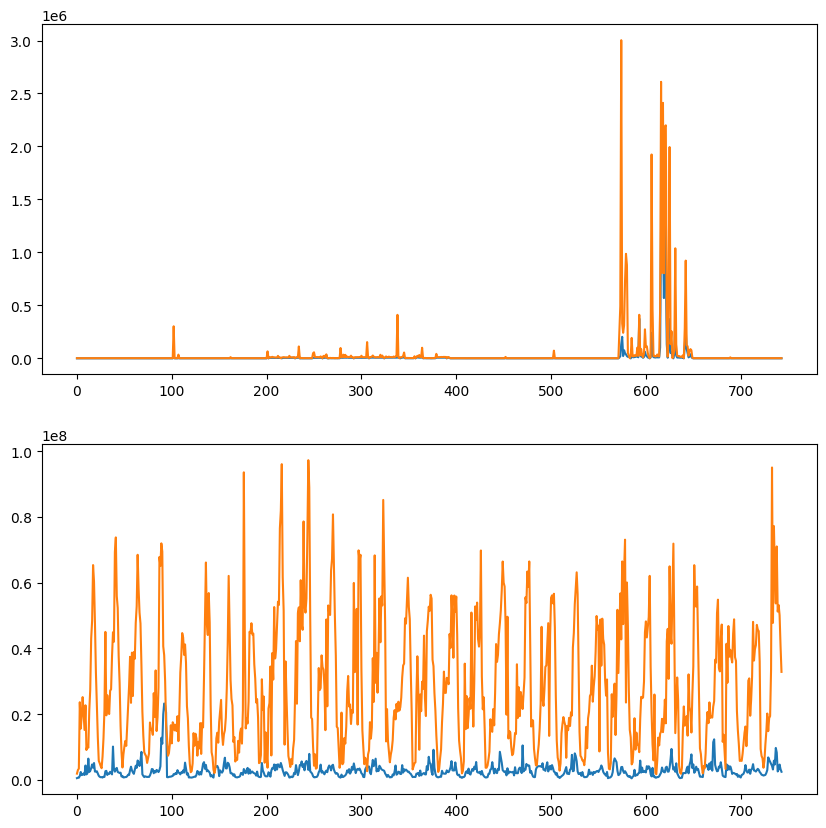

In [44]:
# Build and plot graphs for the average network traffic every hour over a monthlong period
df = pd.DataFrame()
df["time"] = pd.DataFrame.from_records(dataset[0])["clock"]
i = 0
for item in dataset:
    df_temp = pd.DataFrame.from_records(item)
    df[str(i)] = df_temp["value_avg"].astype(int)
    i += 1
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(df["0"])
ax[0].plot(df["1"])
ax[1].plot(df["2"])
ax[1].plot(df["3"])